# RTS-96 results with new distributed slack

Start-to-finish RTS-96 results.

In [1]:
####### IMPORTS: DATA ACQUISITION ########
include("../src/tmp_inst_rts96.jl")

psData = psDataLoad()

# unpack psDL (boilerplate):
(Sb,f,t,r,x,b,Y,bustype,
Gp,Gq,Dp,Dq,Rp,Rq,
Pmax,Pmin,Qmax,Qmin,Plim,
Vg,Vceiling,Vfloor,
busIdx,N,Nr,Ng,k) = unpack_psDL(psData)

####### IMPORTS: INSTANTON CODE ########
# Get instanton code into workspace:
include("../src/TemporalInstanton.jl")
include("../src/TrustRegionSubproblem.jl")

using TemporalInstanton, TrustRegionSubproblem

####### DATA LINKING ########
# Static
Ridx = find(Rp) # Vector of renewable nodes
Y = full(Y) # Full admittance matrix (ref not removed)
ref = 1 # Index of ref node
k = k # Conventional generator participation factors
tau = 1. # Heating constant
G0 = [Gp,Gp.*0.95,Gp.*0.9]
D = [Dp,Dp.*0.95,Dp.*0.9]
P0 = [Rp,Rp,Rp]
kQobj = 0 # Should always be zero; objective has no constant term
c = 5. # RHS of line temperature constraint
kQtheta = -c # Move to LHS so we have Q(z) = 0

# Changing:
lines = [(f[i],t[i]) for i in 1:length(f)];

In [2]:
# For a single line:
line = lines[48]

# Create instance of instanton problem
Qobj,A,b,Qtheta = temporalInstanton(Ridx,Y,ref,k,tau,line,G0,P0,D)

G_of_x = (Qobj,0,kQobj)
Q_of_x = (Qtheta,0,kQtheta)

# Translate and rotate twice
J_of_z,K_of_w,R_of_x,x_star,Rkernel,Reigvec = tr_trans_rotate(G_of_x,Q_of_x,A,b)

# Prepare to solve the secular equation:
Qtheta = full(R_of_x[1])
D = K_of_w[1]
d = K_of_w[2]./2
d2 = Reigvec*Rkernel*R_of_x[2]
c = -R_of_x[3]

4.943387160148831

In [3]:
# Check 0 and diagonals of D before doing binary search
mu_vals,w_vals,check = tr_check_diag(D,d,d2,Qtheta,c)
# If all values of "check" are false, continue:
if all(!check)
# continue
else
display(mu_vals[find(check)])
end

# Solve secular equation:
solutions,vectors = tr_solve_secular(D,d,d2,Qtheta,c)

# Translate back to original variables:
xvec = tr_map_back(vectors[1],Rkernel,Reigvec,x_star)

T = int(length(G0)/size(Y,1))
deviations = Array(Vector{Float64},0)
angles = Array(Vector{Float64},0)
alpha = Float64[]
anglediffs = xvec[end-T+1:end]
n = size(Y,1)
nr = length(Ridx)

# Variable breakdown:
# (nr+n+1) per time step
#   First nr are deviations
#   Next n are angles
#   Last is mismatch
# T variables at the end: anglediffs
for t = 1:T
push!(deviations,xvec[(nr+n+1)*(t-1)+1:(nr+n+1)*(t-1)+nr])
push!(angles,xvec[(nr+n+1)*(t-1)+nr+1:(nr+n+1)*(t-1)+nr+n])
push!(alpha,xvec[(nr+n+1)*(t)])
end
[A*xvec-b]

225-element Array{FloatingPoint,1}:
  1.15463e-14
 -1.85692    
 -4.4631e-14 
  4.76841e-14
  1.44329e-14
  1.02141e-14
 -8.88178e-16
 -1.18239e-14
 -1.9762e-14 
 -3.9968e-14 
  1.64938e-13
  1.53211e-14
 -1.2057e-13 
  ⋮          
  1.65867e-13
 -2.37588e-14
 -4.78506e-14
 -2.10054e-13
  2.93099e-14
  1.66978e-13
 -1.42109e-14
 -7.81597e-14
 -5.47622e-16
  1.94289e-16
 -2.52576e-15
 -2.35922e-15

In [5]:
deviations[1]

18-element Array{Float64,1}:
  0.620169 
 -0.136963 
 -0.252248 
 -0.275207 
  0.281728 
  0.0484629
  0.403906 
 -0.0161078
 -0.417756 
  0.255967 
 -0.449592 
  0.261259 
 -0.204286 
  0.152381 
 -0.0510083
 -0.166319 
 -0.114272 
 -0.43611  

In [6]:
angles[1]

73-element Array{Float64,1}:
 -2.72413e-15
 -0.00833818 
  0.00287657 
 -0.0328862  
 -0.0313467  
 -0.0607024  
  0.0241897  
 -0.00480185 
 -0.00270028 
 -0.0228849  
  0.0344431  
  0.0769653  
  0.126547   
  ⋮          
  0.22313    
  0.421103   
  0.404059   
  0.464688   
  0.477921   
  0.378658   
  0.380374   
  0.504838   
  0.61029    
  0.390525   
  0.294316   
  0.378482   

In [7]:
alpha

3-element Array{Float64,1}:
 -2.06417
 -1.97214
 -1.88012

In [14]:
using PyPlot

LoadError: PyPlotj not found
while loading In[14], in expression starting on line 1

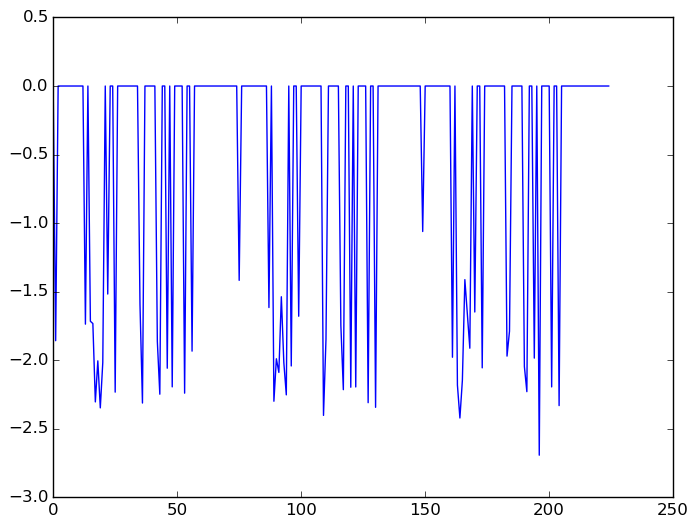

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f2045391590>

In [15]:
plot(A*xvec-b)

In [22]:
anglediffs

3-element Array{FloatingPoint,1}:
 -0.144441
 -0.137246
 -0.130051

In [18]:
sum(Dp) - sum(Gp) - sum(Rp) - sum(deviations[1])

-37.9609694287125

Not getting any solutions. Let's plot the secular equation:

In [3]:
using Interact
using PyPlot

INFO: Loading help data...


Slider{Float64}([Input{Float64}] 25.0,"cval",25.0,20.0:0.5:30.0)

[0.8816833053861046,1.1183166946138954]

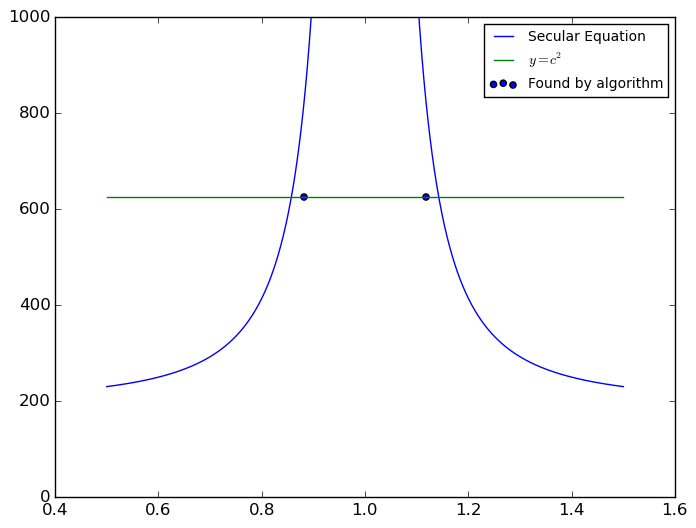

In [4]:
poles = [D[i,i]*Qtheta[i,i] for i in setdiff(1:size(D,1),find(diag(Qtheta).==0))]
mu_vals = linspace(0.5*minimum(poles),1.5*maximum(poles),1000)

fig = figure()
@manipulate for cval = 20:0.5:30; withfig(fig) do
        solutions,vectors = tr_solve_secular(D,d,d2,Qtheta,cval)
        print(solutions)
        s_vals = [sumabs2(find_w(mu,D,d,d2,Qtheta)) for mu in mu_vals]
        plot(mu_vals,s_vals)
        hold = true
        plot([mu_vals[1],mu_vals[end]],[cval^2,cval^2])
        ylim([0,1000]) #ylim([0,2*c^2])
        xlim = [mu_vals[1],mu_vals[end]]
        scatter(solutions,cval^2*ones(length(solutions)))
        legend(["Secular Equation",L"y = c^2","Found by algorithm"],fontsize=10)
    end
end

In [13]:
solutions,vectors = tr_solve_secular(D,d,d2,Qtheta,3)

([0.0140275,1.98597],[[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  -2.88108,-1.09484,1.31121,0.561054,-3.51584,0.540241,-1.9572,2.47885,0.638731,-1.5644],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  -2.88108,-1.09484,1.31121,0.561054,-3.51584,0.540241,-1.9572,-2.47885,-0.638731,1.5644]])

In [11]:
solutions

2-element Array{Float64,1}:
 0.0140275
 1.98597  

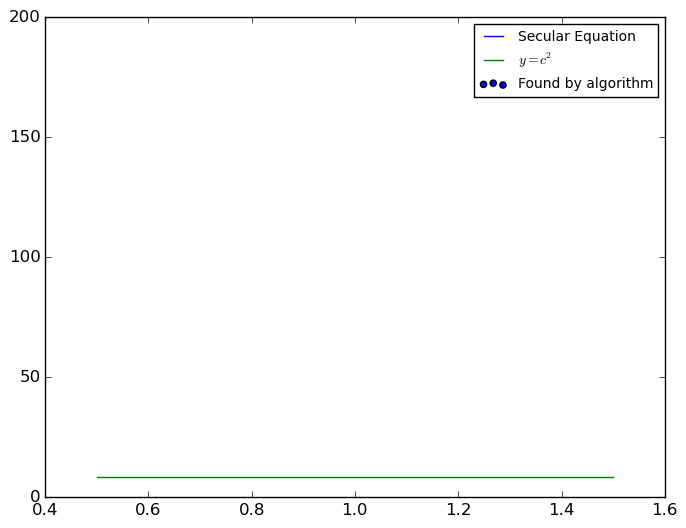

PyObject <matplotlib.legend.Legend object at 0x7ff0a84b0c10>

In [21]:
        solutions,vectors = tr_solve_secular(D,d,d2,Qtheta,c)

        s_vals = [sumabs2(find_w(mu,D,d,d2,Qtheta)) for mu in mu_vals]
        plot(mu_vals,s_vals)
        hold = true
        plot([mu_vals[1],mu_vals[end]],[c^2,c^2])
        ylim([0,200]) #ylim([0,2*c^2])
        xlim = [mu_vals[1],mu_vals[end]]
        scatter(solutions,c^2*ones(length(solutions)))
        legend(["Secular Equation",L"y = c^2","Found by algorithm"],fontsize=10)

1000-element Array{Any,1}:
 230.873
 231.014
 231.155
 231.298
 231.441
 231.585
 231.73 
 231.875
 232.022
 232.169
 232.318
 232.467
 232.618
   ⋮    
 232.467
 232.318
 232.169
 232.022
 231.875
 231.73 
 231.585
 231.441
 231.298
 231.155
 231.014
 230.873